First draft of comparative allele analysis between DK0911 and Pst_104E

In [2]:
%matplotlib inline

In [295]:
import pandas as pd
import os
import shutil
from Bio import SeqIO
from Bio import AlignIO
import distance
import editdistance
import math
import subprocess
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
import pybedtools
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import scipy.stats as stats
import matplotlib

In [4]:
OUT_PATH = '/home/benjamin/genome_assembly/Warrior/allele_analysis/v04/post_analysis/'
DK0911_fh = '/home/benjamin/genome_assembly/Warrior/allele_analysis/v04/post_analysis/DK_0911_v04_analysed_alleles.df'
Pst_104E_v12_fh = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/allele_analysis/post_allele_analysis/Pst_104E_v12_analysed_alleles.df'

In [5]:
Pst_104E_df = pd.read_csv(Pst_104E_v12_fh, sep='\t')
DK0911_df = pd.read_csv(DK0911_fh, sep='\t')

/home/benjamin/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
DK0911_df.columns

Index(['Unnamed: 0', 'Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap',
       'StartQuery', 'StopQuery', 'StartTarget', 'StopTarget', 'e-value',
       'BitScore', 'QLgth', 'QCov', 'TLgth', 'TCov', 'q_contig', 't_contig',
       'q_contig == t_contig', 't_contig == h_contig_overlap', 'allele_source',
       'matchType', 'aQuery', 'aTarget', 'comp', 'aQuery_LT', 'aTarget_LT',
       'Index', 'protein_hamming', 'protein_levenshtein', 'cds_hamming',
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS', 'LWL85m_dN/dS',
       'LPB93_dN/dS', 'unphased_aQuery', 'PO_single_aQuery',
       'PO_single_aTarget', 'PO_interhaplotype_paralogs'],
      dtype='object')

In [7]:
DK0911_df.allele_source.unique()

array(['BLAST', 'PO', 'h_rBLAST', nan], dtype=object)

In [8]:
DK0911_df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
Pst_104E_df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
allele_filter = ()

In [11]:
DK0911_alleles_df = DK0911_df[DK0911_df.allele_source.astype(str).str.contains('PO')]

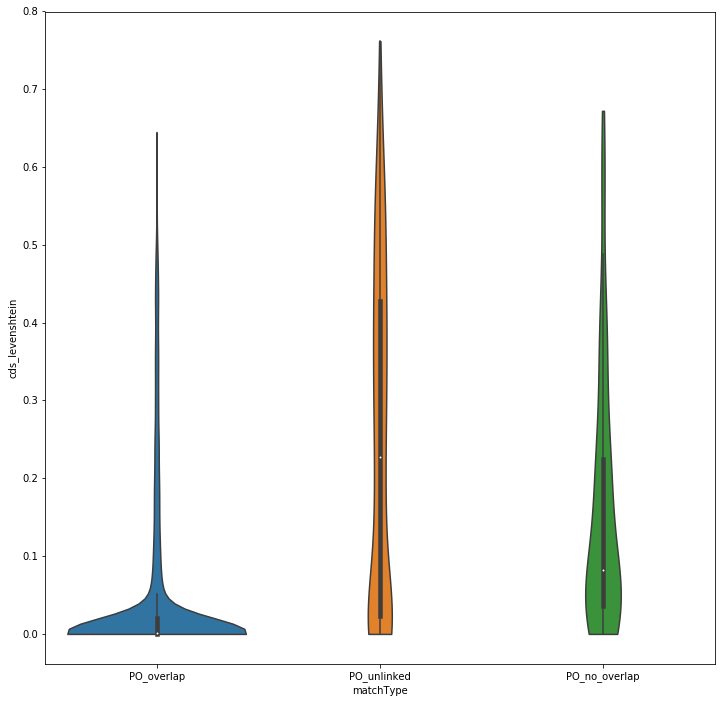

In [12]:
plt.figure(figsize=(12,12))
sns.violinplot(y='cds_levenshtein', x='matchType', data=DK0911_alleles_df, cut=0)

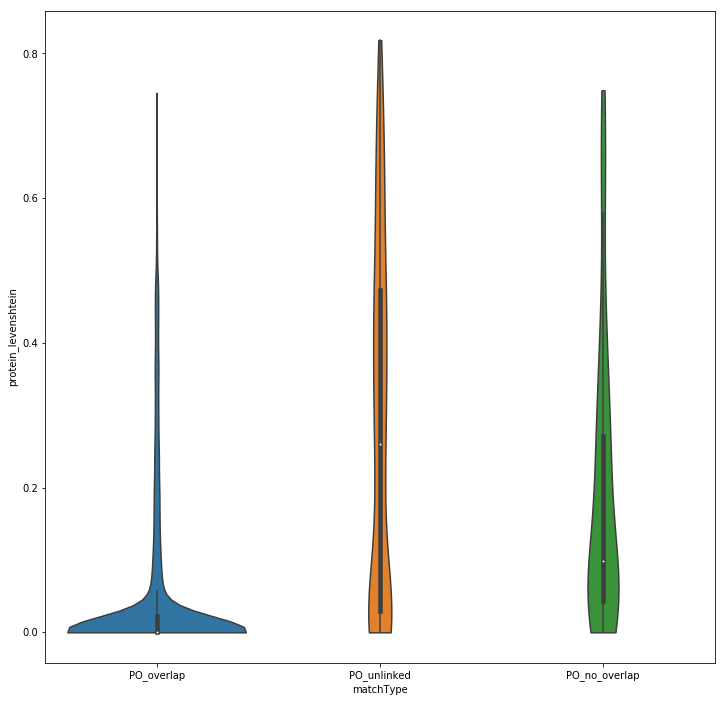

In [13]:
plt.figure(figsize=(12,12))
sns.violinplot(y='protein_levenshtein', x='matchType', data=DK0911_alleles_df, cut=0)

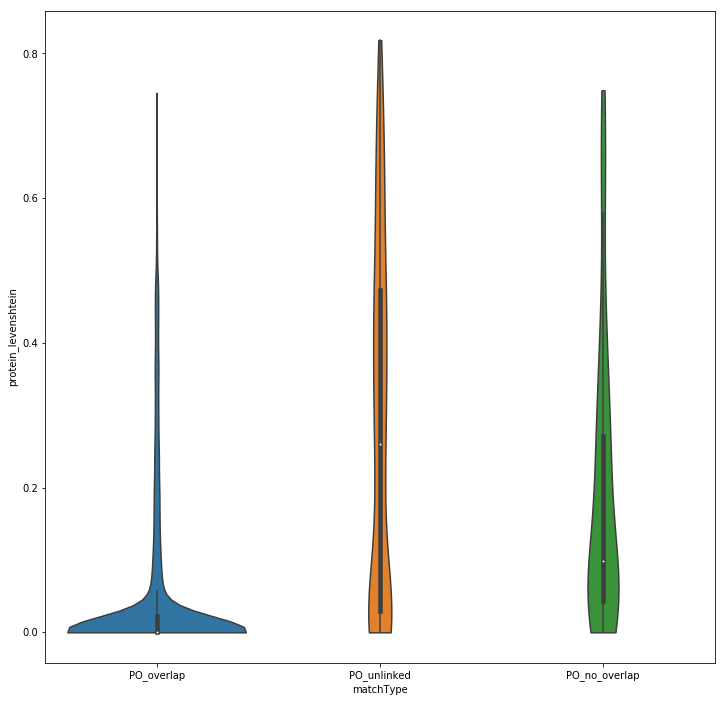

In [14]:
plt.figure(figsize=(12,12))
sns.violinplot(y='protein_levenshtein', x='matchType', data=DK0911_alleles_df, cut=0)

In [15]:
DK0911_allele_summary = DK0911_alleles_df.loc[:, [ 'protein_levenshtein', 
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS' ]].describe().round(3)

In [16]:
DK0911_allele_summary

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS
count,8142.000,8142.000,3473.000,3483.000
mean,0.066,0.059,0.507,0.657
std,0.138,0.125,0.655,4.563
min,0.000,0.000,-0.000,0.000
25%,0.000,0.000,0.082,0.077
50%,0.002,0.002,0.400,0.291
75%,0.040,0.034,0.725,0.640
max,0.818,0.761,13.620,149.000


In [17]:
Pst_104E_df_alleles_df = Pst_104E_df[Pst_104E_df.allele_source.astype(str).str.contains('PO')]

In [18]:
Pst_104E__allele_summary = Pst_104E_df_alleles_df.loc[:, [ 'protein_levenshtein', 
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS' ]].describe().round(3)

In [19]:
Pst_104E__allele_summary 

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS
count,11007.000,11007.000,6944.000,6973.000
mean,0.058,0.053,0.408,0.456
std,0.119,0.109,0.514,3.469
min,0.000,0.000,-0.000,0.000
25%,0.000,0.001,0.069,0.064
50%,0.007,0.007,0.260,0.210
75%,0.041,0.035,0.581,0.475
max,0.806,0.733,10.429,166.000


In [20]:
DK0911_allele_summary['protein_identity'] = (1 - DK0911_allele_summary.protein_levenshtein) * 100
DK0911_allele_summary['cds_identity'] = (1 - DK0911_allele_summary.cds_levenshtein) * 100
Pst_104E__allele_summary ['protein_identity'] = (1 - Pst_104E__allele_summary.protein_levenshtein) * 100
Pst_104E__allele_summary ['cds_identity'] = (1 - Pst_104E__allele_summary.cds_levenshtein) * 100

In [21]:
Pst_104E_df_alleles_df.loc[Pst_104E_df_alleles_df[Pst_104E_df_alleles_df.matchType == 'PO_no_overlap'].index, 'matchType'] = 'Alleles with local rearrangement'

/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
Pst_104E_df_alleles_df.loc[(Pst_104E_df_alleles_df.matchType == 'PO_overlap'),'matchType'] = "Classic alleles"

/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
Pst_104E_df_alleles_df.loc[(Pst_104E_df_alleles_df.matchType == 'PO_unlinked'),'matchType'] = "Unlinked alleles"

/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
Pst_104E_df_alleles_df.groupby('matchType')['protein_levenshtein', 
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS' ].describe().round(3).\
T.loc[:,['Classic alleles','Alleles with local rearrangement', 'Unlinked alleles']]

matchType                  Classic alleles  Alleles with local rearrangement  \
protein_levenshtein count         9818.000                           455.000   
                    mean             0.045                             0.117   
                    std              0.097                             0.144   
                    min              0.000                             0.000   
                    25%              0.000                             0.019   
                    50%              0.005                             0.050   
                    75%              0.029                             0.156   
                    max              0.718                             0.636   
cds_levenshtein     count         9818.000                           455.000   
                    mean             0.042                             0.104   
                    std              0.092                             0.130   
                    min              0.000                             0.003   
                    25%              0.000                             0.023   
                    50%              0.005                             0.039   
                    75%              0.027                             0.136   
                    max              0.644                             0.608   
yn00_dN/dS          count         5939.000                           448.000   
                    mean             0.388                             0.444   
                    std              0.485                             0.623   
                    min             -0.000                            -0.000   
                    25%              0.058                             0.114   
                    50%              0.236                             0.314   
                    75%              0.548                             0.585   
                    max              6.360                             7.301   
LWL85_dN/dS         count         5988.000                           449.000   
                    mean             0.438                             0.695   
                    std              3.068                             7.827   
                    min              0.000                             0.000   
                    25%              0.055                             0.102   
                    50%              0.190                             0.252   
                    75%              0.448                             0.471   
                    max            126.000                           166.000   

matchType                  Unlinked alleles  
protein_levenshtein count           734.000  
                    mean              0.197  
                    std               0.222  
                    min               0.000  
                    25%               0.007  
                    50%               0.111  
                    75%               0.345  
                    max               0.806  
cds_levenshtein     count           734.000  
                    mean              0.169  
                    std               0.194  
                    min               0.000  
                    25%               0.004  
                    50%               0.087  
                    75%               0.306  
                    max               0.733  
yn00_dN/dS          count           557.000  
                    mean              0.594  
                    std               0.662  
                    min              -0.000  
                    25%               0.212  
                    50%               0.480  
                    75%               0.783  
                    max              10.429  
LWL85_dN/dS         count           536.000  
                    mean              0.456  
                    std               0.400  
                    min               0.000  
                    25%  

In [25]:
DK0911_alleles_df.loc[DK0911_alleles_df[DK0911_alleles_df.matchType == 'PO_no_overlap'].index, 'matchType'] = 'Alleles with local rearrangement'
DK0911_alleles_df.loc[DK0911_alleles_df[DK0911_alleles_df.matchType == 'PO_unlinked'].index, 'matchType'] = "Unlinked alleles"
DK0911_alleles_df.loc[DK0911_alleles_df[DK0911_alleles_df.matchType == 'PO_overlap'].index, 'matchType'] = "Classic alleles"


/home/benjamin/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
DK0911_alleles_df.groupby('matchType')['protein_levenshtein', 
       'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS' ].describe().round(3).\
T.loc[:,['Classic alleles','Alleles with local rearrangement', 'Unlinked alleles']]

matchType                  Classic alleles  Alleles with local rearrangement  \
protein_levenshtein count         7565.000                            97.000   
                    mean             0.050                             0.193   
                    std              0.112                             0.197   
                    min              0.000                             0.000   
                    25%              0.000                             0.043   
                    50%              0.001                             0.099   
                    75%              0.023                             0.271   
                    max              0.746                             0.749   
cds_levenshtein     count         7565.000                            97.000   
                    mean             0.046                             0.158   
                    std              0.105                             0.162   
                    min              0.000                             0.000   
                    25%              0.000                             0.036   
                    50%              0.001                             0.082   
                    75%              0.021                             0.225   
                    max              0.645                             0.672   
yn00_dN/dS          count         2997.000                            94.000   
                    mean             0.493                             0.657   
                    std              0.642                             0.929   
                    min             -0.000                            -0.000   
                    25%              0.048                             0.271   
                    50%              0.392                             0.429   
                    75%              0.720                             0.692   
                    max             13.620                             6.635   
LWL85_dN/dS         count         3028.000                            94.000   
                    mean             0.643                             0.481   
                    std              4.591                             0.546   
                    min              0.000                             0.026   
                    25%              0.054                             0.216   
                    50%              0.286                             0.350   
                    75%              0.643                             0.552   
                    max            149.000                             4.057   

matchType                  Unlinked alleles  
protein_levenshtein count           480.000  
                    mean              0.281  
                    std               0.246  
                    min               0.000  
                    25%               0.030  
                    50%               0.260  
                    75%               0.472  
                    max               0.818  
cds_levenshtein     count           480.000  
                    mean              0.247  
                    std               0.216  
                    min               0.000  
                    25%               0.023  
                    50%               0.227  
                    75%               0.427  
                    max               0.761  
yn00_dN/dS          count           382.000  
                    mean              0.582  
                    std               0.668  
                    min              -0.000  
                    25%               0.215  
                    50%               0.428  
                    75%               0.758  
                    max               9.024  
LWL85_dN/dS         count           361.000  
                    mean              0.822  
                    std               4.904  
                    min               0.000  
                    25%  

In [27]:
def ranksumtest(df1, df2, matchType, to_test):
    return stats.ranksums\
    (df1.loc[df1.matchType == matchType, to_test],df2.loc[df2.matchType == matchType, to_test] )

In [28]:
DK0911_alleles_df.matchType

11188                     Classic alleles
11189                     Classic alleles
11190                     Classic alleles
11191                     Classic alleles
11192                     Classic alleles
11193                     Classic alleles
11194                     Classic alleles
11195                     Classic alleles
11196                    Unlinked alleles
11197                     Classic alleles
11198                     Classic alleles
11199                    Unlinked alleles
11200                     Classic alleles
11201                     Classic alleles
11202                     Classic alleles
11203                     Classic alleles
11204                     Classic alleles
11205                     Classic alleles
11206                     Classic alleles
11207                     Classic alleles
11208                     Classic alleles
11209                     Classic alleles
11210                     Classic alleles
11211    Alleles with local rearra

In [29]:
ranksumtest(DK0911_alleles_df, Pst_104E_df_alleles_df, 'Classic alleles', 'protein_levenshtein')

RanksumsResult(statistic=-15.57065819304386, pvalue=1.1521550893099653e-54)

In [30]:
ranksumtest(DK0911_alleles_df, Pst_104E_df_alleles_df, 'Classic alleles', 'cds_levenshtein')

RanksumsResult(statistic=-20.109243886199039, pvalue=6.1250368276108139e-90)

In [31]:
ranksumtest(DK0911_alleles_df, Pst_104E_df_alleles_df, 'Unlinked alleles', 'protein_levenshtein')

RanksumsResult(statistic=6.0476630877193465, pvalue=1.4696187424831132e-09)

In [32]:
ranksumtest(DK0911_alleles_df, Pst_104E_df_alleles_df, 'Alleles with local rearrangement', 'protein_levenshtein')

RanksumsResult(statistic=4.4101424066051775, pvalue=1.0330266239890078e-05)

In [33]:
DK0911_allele_summary

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,protein_identity,cds_identity
count,8142.000,8142.000,3473.000,3483.000,-814100.0,-814100.0
mean,0.066,0.059,0.507,0.657,93.4,94.1
std,0.138,0.125,0.655,4.563,86.2,87.5
min,0.000,0.000,-0.000,0.000,100.0,100.0
25%,0.000,0.000,0.082,0.077,100.0,100.0
50%,0.002,0.002,0.400,0.291,99.8,99.8
75%,0.040,0.034,0.725,0.640,96.0,96.6
max,0.818,0.761,13.620,149.000,18.2,23.9


In [34]:
Pst_104E__allele_summary

,protein_levenshtein,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,protein_identity,cds_identity
count,11007.000,11007.000,6944.000,6973.000,-1100600.0,-1100600.0
mean,0.058,0.053,0.408,0.456,94.2,94.7
std,0.119,0.109,0.514,3.469,88.1,89.1
min,0.000,0.000,-0.000,0.000,100.0,100.0
25%,0.000,0.001,0.069,0.064,100.0,99.9
50%,0.007,0.007,0.260,0.210,99.3,99.3
75%,0.041,0.035,0.581,0.475,95.9,96.5
max,0.806,0.733,10.429,166.000,19.4,26.7


In [35]:
Merged_df = pd.concat([DK0911_alleles_df, Pst_104E_df_alleles_df], axis=0).reset_index(drop=True)

In [36]:
def strain(Query_LT):
    if 'DK0911' in Query_LT:
        return 'DK0911'
    elif 'Pst104E' in Query_LT:
        return 'Pst104E'

In [37]:
Merged_df['strain'] = Merged_df.aQuery_LT.apply(strain)

In [42]:
Merged_df.matchType.unique

<bound method Series.unique of 0                         Classic alleles
1                         Classic alleles
2                         Classic alleles
3                         Classic alleles
4                         Classic alleles
5                         Classic alleles
6                         Classic alleles
7                         Classic alleles
8                        Unlinked alleles
9                         Classic alleles
10                        Classic alleles
11                       Unlinked alleles
12                        Classic alleles
13                        Classic alleles
14                        Classic alleles
15                        Classic alleles
16                        Classic alleles
17                        Classic alleles
18                        Classic alleles
19                        Classic alleles
20                        Classic alleles
21                        Classic alleles
22                        Classic alleles
23 

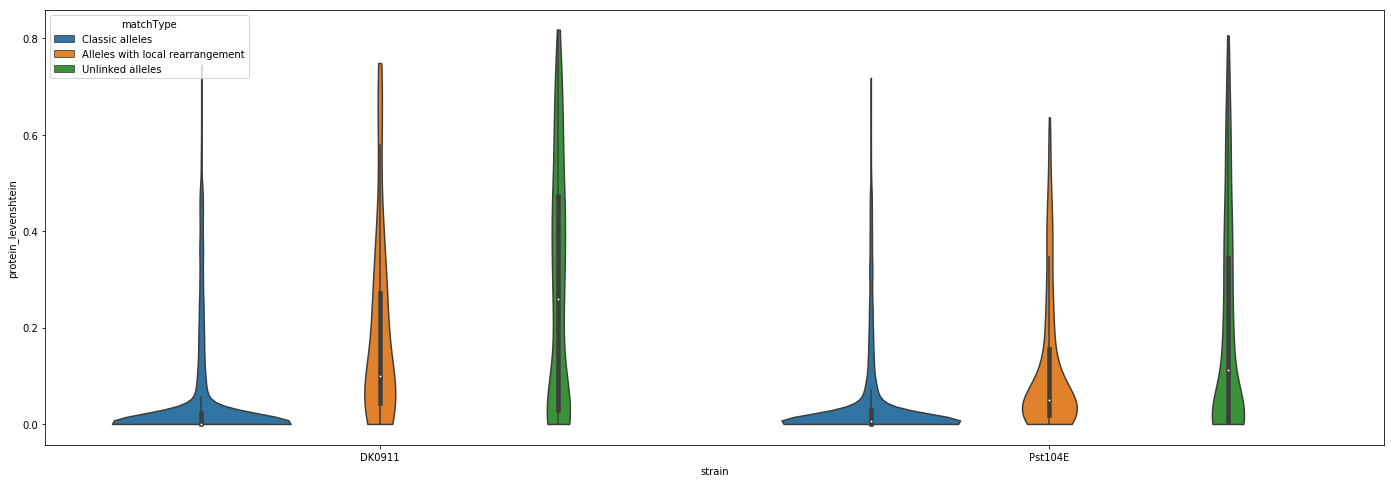

In [44]:
plt.figure(figsize=(24,8))
sns.violinplot(x='strain', y='protein_levenshtein', data=Merged_df, hue='matchType', \
               hue_order=['Classic alleles','Alleles with local rearrangement', 'Unlinked alleles' ] ,cut=0)

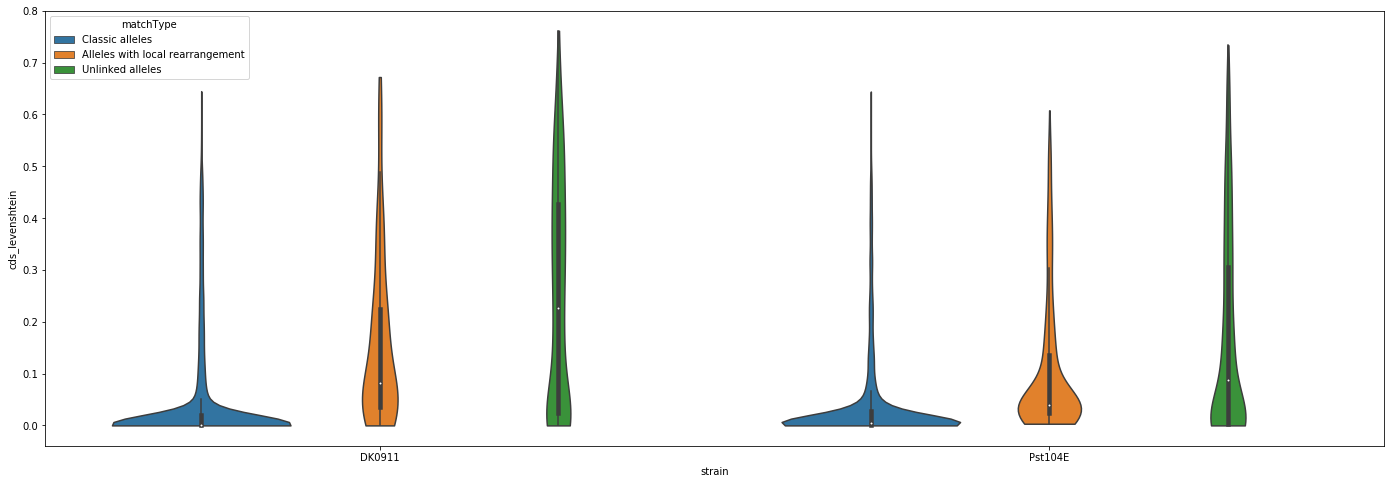

In [45]:
plt.figure(figsize=(24,8))
sns.violinplot(x='strain', y='cds_levenshtein', data=Merged_df, hue='matchType', \
               hue_order=['Classic alleles','Alleles with local rearrangement', 'Unlinked alleles' ] ,cut=0)

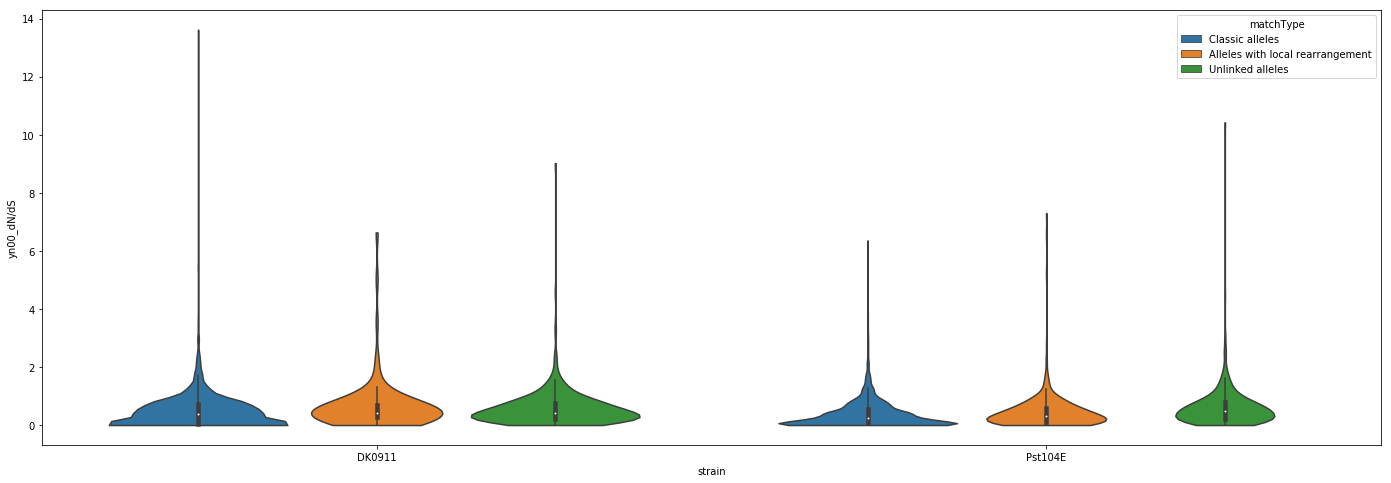

In [46]:
plt.figure(figsize=(24,8))
sns.violinplot(x='strain', y='yn00_dN/dS', data=Merged_df, hue='matchType', \
              hue_order=['Classic alleles','Alleles with local rearrangement', 'Unlinked alleles' ] ,cut=0)

In [ ]:
plt.figure(figsize=(24,8))
sns.swarmplot(y='protein_levenshtein', x='matchType', data=DK0911_alleles_df, size=2, color=".3", linewidth=0)
plt.savefig(os.path.join(OUT_PATH, 'DK0911_matchType_protein_swarmplot.png'))

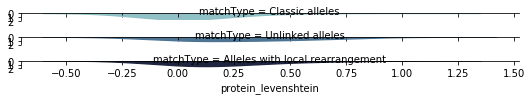

In [47]:
pal = sns.cubehelix_palette(3, rot=-.25, light=.7)
g = sns.FacetGrid(DK0911_alleles_df, row='matchType', hue='matchType', aspect=15, size=.5, palette=pal)
g.map(sns.kdeplot, 'protein_levenshtein', clip_on=True, shade=True, alpha=1, lw=1.5, bw=.2)

In [48]:
import half_viol

In [355]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


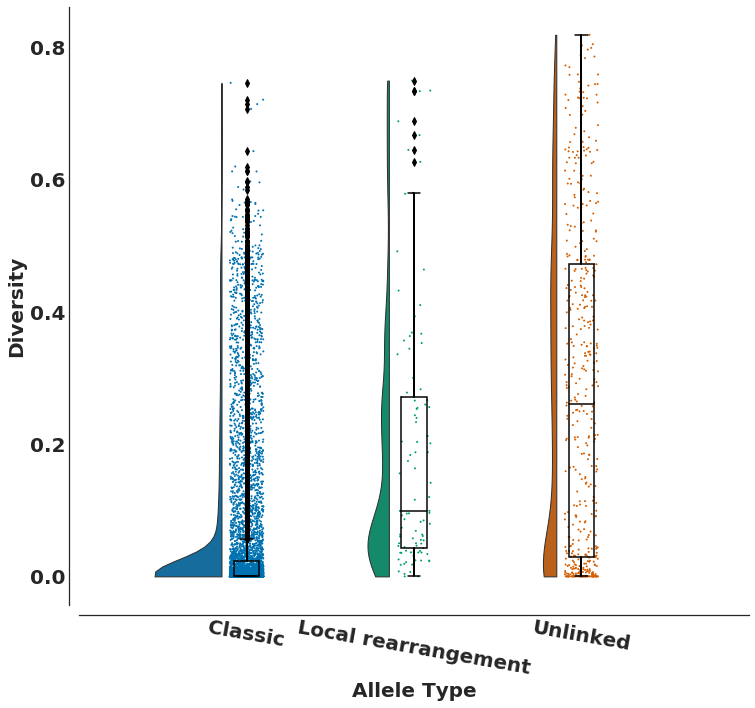

In [359]:
f, ax = plt.subplots(figsize=(12, 11))
sns.set_style("white")
sns.despine(offset=10, trim=False)
ort='v'
order = ['Classic alleles','Alleles with local rearrangement','Unlinked alleles',]
ax=half_viol.violinplot(data=DK0911_alleles_df, palette="colorblind", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8, inner=None,orient=ort,x='matchType',y='protein_levenshtein')


ax=sns.stripplot(data=DK0911_alleles_df, palette="colorblind", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0)

ax=sns.boxplot(data=DK0911_alleles_df, color="black",orient=ort,width=.15,x='matchType',\
               y='protein_levenshtein',zorder=10,\
              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1,\
              order=order)
lables = ["Classic", "Local rearrangement", 'Unlinked']

ax.xaxis.reset_ticks()
ax.xaxis.set_ticklabels(lables)
ax.set_xlim(left=-1, right=3)
plt.ylabel('Diversity', font)
plt.xlabel('Allele Type', font)
plt.xticks(rotation=-10)


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


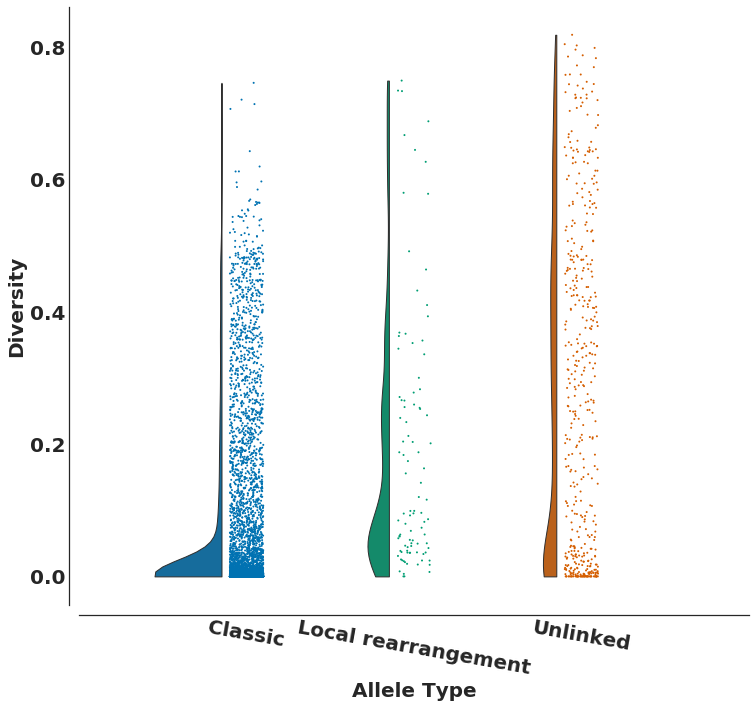

In [345]:
f, ax = plt.subplots(figsize=(12, 11))
sns.set_style("white")
sns.despine(offset=10, trim=False)
ort='v'
order = ['Classic alleles','Alleles with local rearrangement','Unlinked alleles',]
ax=half_viol.violinplot(data=DK0911_alleles_df, palette="colorblind", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8, inner=None,orient=ort,x='matchType',y='protein_levenshtein')


ax=sns.stripplot(data=DK0911_alleles_df, palette="colorblind", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0)


lables = ["Classic", "Local rearrangement", 'Unlinked']


ax.xaxis.reset_ticks()
ax.xaxis.set_ticklabels(lables)
ax.set_xlim(left=-1, right=3)
plt.ylabel('Diversity', font)
plt.xlabel('Allele Type', font)
plt.xticks(rotation=-10)

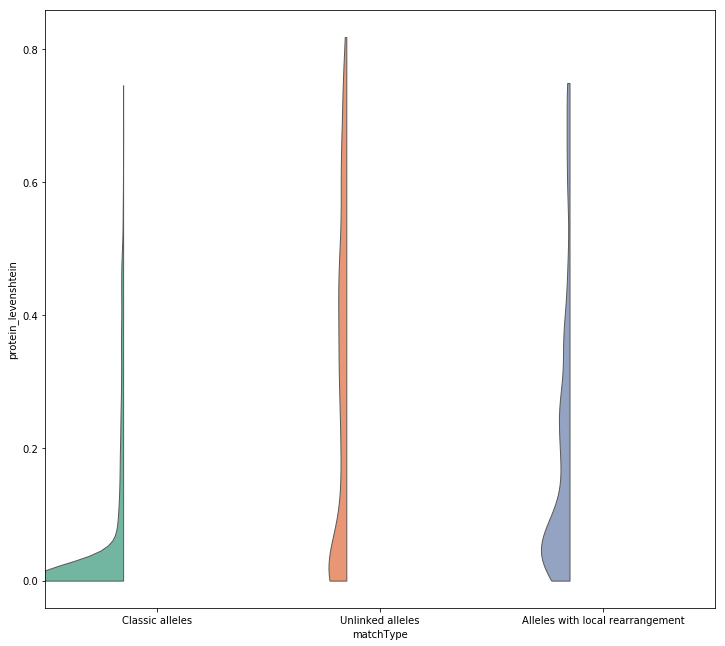

In [55]:
f, ax = plt.subplots(figsize=(12, 11))
ort='v'
ax=half_viol.violinplot(data=DK0911_alleles_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",hue_order=['Classic alleles','Alleles with local rearrangement'], width=.8, inner=None,orient=ort,x='matchType',y='protein_levenshtein')


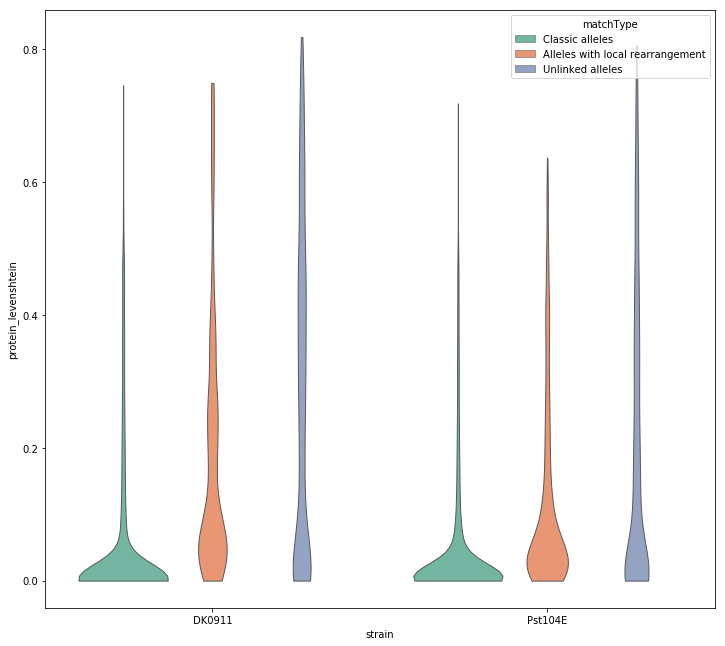

In [61]:
f, ax = plt.subplots(figsize=(12, 11))
ort='v'
ax=half_viol.violinplot(data=Merged_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",hue_order=order, width=.8, inner=None,orient=ort,\
                        x='strain',y='protein_levenshtein',hue='matchType')


In [ ]:
ax2=half_viol.violinplot(data=DK0911_alleles_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8, inner=None,orient=ort,x='matchType',y='protein_levenshtein')


ax2=sns.stripplot(data=DK0911_alleles_df, palette="Set2", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0)

ax2=sns.boxplot(data=DK0911_alleles_df, color="black",orient=ort,width=.15,x='matchType',y='protein_levenshtein',zorder=10,\
              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1,\
              order=order)

(-0.05, 0.84)

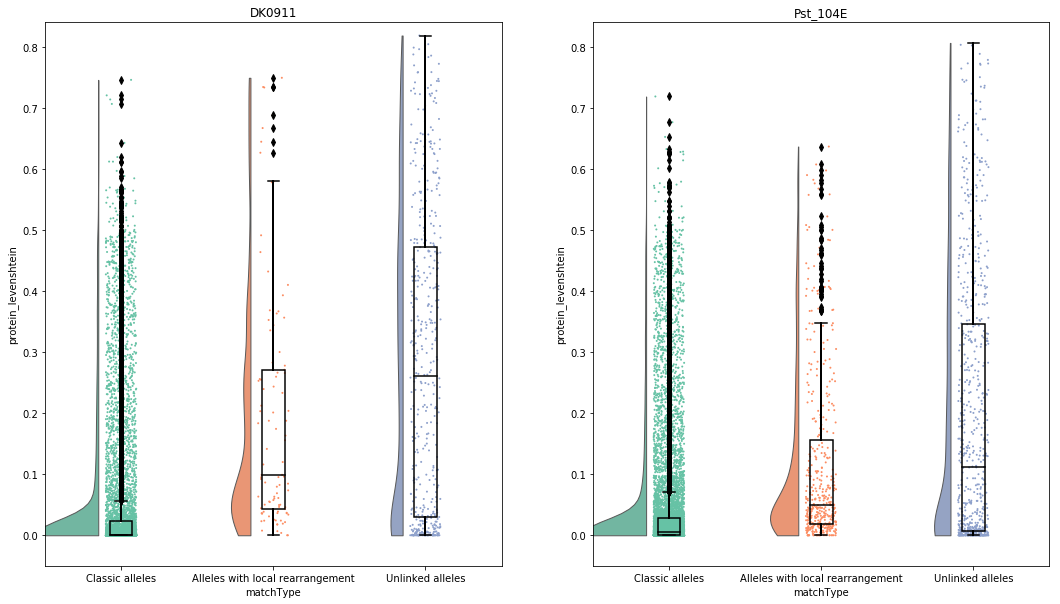

In [293]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 10))
ort='v'

order = ['Classic alleles','Alleles with local rearrangement','Unlinked alleles']
half_viol.violinplot(data=DK0911_alleles_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8, inner=None,orient=ort,x='matchType',\
                     y='protein_levenshtein',ax=ax1)

sns.stripplot(data=DK0911_alleles_df, palette="Set2", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0, ax=ax1)

sns.boxplot(data=DK0911_alleles_df, color="black",orient=ort,width=.15,x='matchType',y='protein_levenshtein',zorder=10,\
              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1,order=order, ax=ax1)
ax1.set_title('DK0911')
ax1.set_ylim(-0.05,0.84)


half_viol.violinplot(data=Pst_104E_df_alleles_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8,ax=ax2, inner=None,orient=ort,x='matchType',y='protein_levenshtein')


sns.stripplot(data=Pst_104E_df_alleles_df, palette="Set2", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0,ax=ax2)

sns.boxplot(data=Pst_104E_df_alleles_df, color="black",orient=ort,width=.15,x='matchType',y='protein_levenshtein',zorder=10,\
              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1,\
              order=order,ax=ax2)
ax2.set_title('Pst_104E')
ax2.set_ylim(-0.05,0.84)

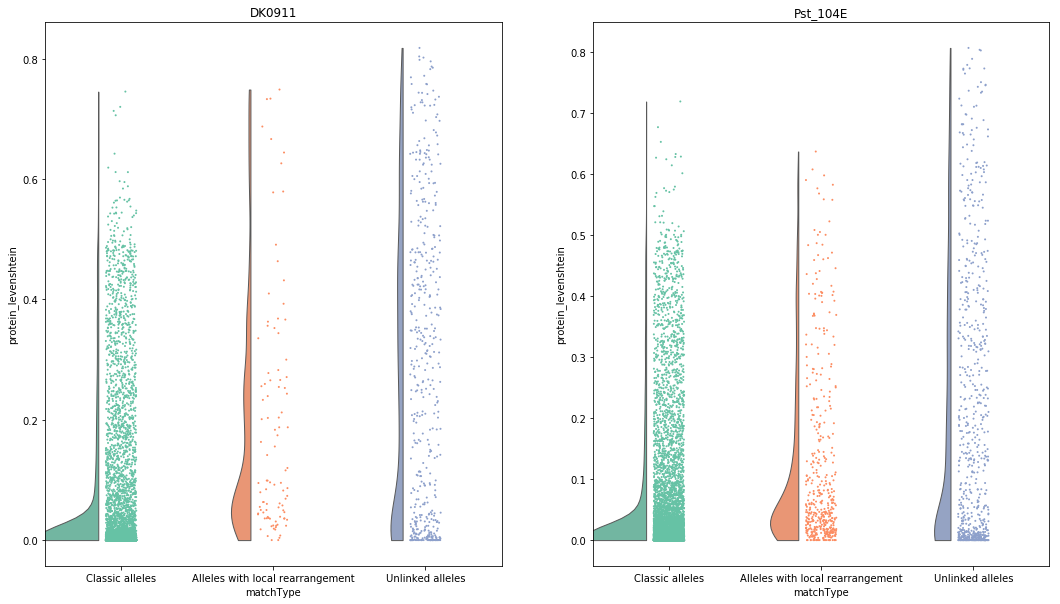

In [88]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 10))
ort='v'
order = ['Classic alleles','Alleles with local rearrangement','Unlinked alleles',]
half_viol.violinplot(data=DK0911_alleles_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8, inner=None,orient=ort,x='matchType',\
                     y='protein_levenshtein',ax=ax1)


sns.stripplot(data=DK0911_alleles_df, palette="Set2", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0, ax=ax1)

#sns.boxplot(data=DK0911_alleles_df, color="black",orient=ort,width=.15,x='matchType',y='protein_levenshtein',zorder=10,\
#              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
#               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1,order=order, ax=ax1)
ax1.set_title('DK0911')

half_viol.violinplot(data=Pst_104E_df_alleles_df, palette="Set2", bw=.2,  linewidth=1,cut=0.,\
                   scale="area",order=order, width=.8,ax=ax2, inner=None,orient=ort,x='matchType',y='protein_levenshtein')


sns.stripplot(data=Pst_104E_df_alleles_df, palette="Set2", edgecolor="white",size=2,orient=ort,\
                 x='matchType',y='protein_levenshtein',order=order,jitter=1,zorder=0,ax=ax2)

#sns.boxplot(data=Pst_104E_df_alleles_df, color="black",orient=ort,width=.15,x='matchType',y='protein_levenshtein',zorder=10,\
#              showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
#               showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1,\
#              order=order,ax=ax2)
ax2.set_title('Pst_104E')

In [272]:
Merged_df['cds_levenshtein_bins'] = pd.cut(Merged_df.cds_levenshtein, 10, include_lowest=True)

In [273]:
Merged_df_cds_lev_bind = Merged_df.groupby(['strain','matchType','cds_levenshtein_bins'])['Query'].count().unstack().T

In [274]:
new_index = [x.mid for x in Merged_df_cds_lev_bind.index]

In [275]:
Merged_df_cds_lev_bind.index = new_index

In [276]:
df = Merged_df_cds_lev_bind

In [277]:
df

strain                              DK0911                                   \
matchType Alleles with local rearrangement Classic alleles Unlinked alleles   
0.03717                               47.0          6316.0            163.0   
0.11405                               11.0           368.0             41.0   
0.19000                               16.0           265.0             36.0   
0.26650                                5.0           201.0             45.0   
0.34300                                7.0           165.0             47.0   
0.41900                                5.0           154.0             45.0   
0.49500                                1.0            86.0             42.0   
0.57100                                3.0             8.0             35.0   
0.64700                                2.0             2.0             18.0   
0.72300                                NaN             NaN              8.0   

strain                             Pst104E                                   
matchType Alleles with local rearrangement Classic alleles Unlinked alleles  
0.03717                              302.0          8414.0            356.0  
0.11405                               52.0           506.0             80.0  
0.19000                               33.0           294.0             66.0  
0.26650                               18.0           204.0             46.0  
0.34300                               19.0           169.0             51.0  
0.41900                               16.0           150.0             47.0  
0.49500                               10.0            67.0             43.0  
0.57100                                5.0             9.0             21.0  
0.64700                                NaN             5.0             19.0  
0.72300                                NaN             NaN              5.0

In [278]:
df['DK0911','strain'] ='DK0911'
df['Pst104E','strain'] ='Pst104E'
df = df.sort_index(axis=1) 

In [279]:
df['DK0911',"Classic alleles norm"] = df['DK0911']["Classic alleles"]/df['DK0911']["Classic alleles"].sum()
df['Pst104E', "Unlinked alleles norm"] = df['Pst104E']["Unlinked alleles"]/df['Pst104E']["Unlinked alleles"].sum()

In [280]:
df['Pst104E', "Classic alleles norm"] = df['Pst104E']["Classic alleles"]/df['Pst104E']["Classic alleles"].sum()
df['DK0911', "Unlinked alleles norm"] = df['DK0911']["Unlinked alleles"]/df['DK0911']["Unlinked alleles"].sum()

In [281]:
df2 = pd.concat([df['DK0911'],df['Pst104E']])

In [282]:
len(df.index)

10

In [283]:
len(df2)

20

In [284]:
df2['y'] = df2.index

In [285]:
df2

,Alleles with local rearrangement,Classic alleles,Classic alleles norm,Unlinked alleles,Unlinked alleles norm,strain,y
0.03717,47.0,6316.0,0.834898,163.0,0.339583,DK0911,0.03717
0.11405,11.0,368.0,0.048645,41.0,0.085417,DK0911,0.11405
0.19000,16.0,265.0,0.035030,36.0,0.075000,DK0911,0.19000
0.26650,5.0,201.0,0.026570,45.0,0.093750,DK0911,0.26650
0.34300,7.0,165.0,0.021811,47.0,0.097917,DK0911,0.34300
0.41900,5.0,154.0,0.020357,45.0,0.093750,DK0911,0.41900
0.49500,1.0,86.0,0.011368,42.0,0.087500,DK0911,0.49500
0.57100,3.0,8.0,0.001058,35.0,0.072917,DK0911,0.57100
0.64700,2.0,2.0,0.000264,18.0,0.037500,DK0911,0.64700
0.72300,NaN,NaN,NaN,8.0,0.016667,DK0911,0.72300


In [286]:
import altair as alt

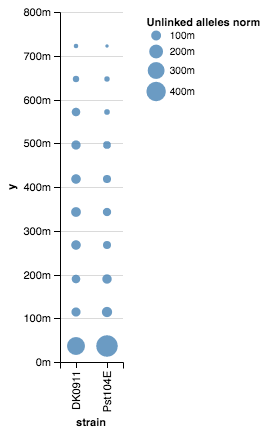

In [289]:
alt.Chart(df2).mark_circle(opacity=0.8,stroke='black',strokeWidth=1).encode(alt.X('strain'),\
    alt.Y('y'), alt.Size('Unlinked alleles norm'))